# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
import hashlib
import os
import pickle
from urllib.request import urlretrieve

import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile

print('All modules imported.')

All modules imported.


In [2]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = train['coords']

# TODO: how many classes are in the dataset
n_classes = max(y_train)+1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [[30 29]
 [30 30]
 [30 30]
 ..., 
 [62 58]
 [69 63]
 [69 68]]
Number of classes = 43


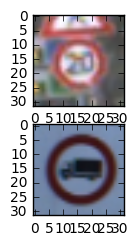

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
%matplotlib inline

plt_train = plt.subplot(311)
plt_train.imshow(X_train[0])
# plt.imshow(X_train[n_train - 1])

plt_test = plt.subplot(312)
plt_test.imshow(X_test[0])
# plt.imshow(X_test[n_test - 1])



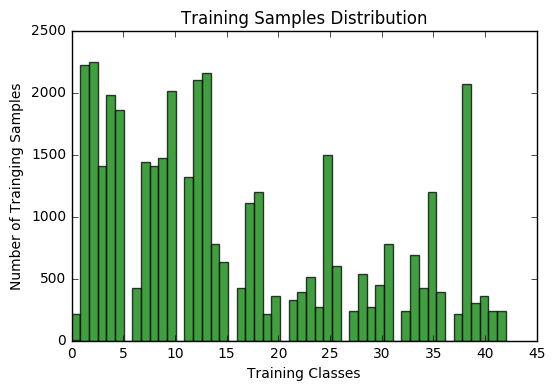

In [5]:
plt.hist(y_train, 50, facecolor='green', alpha=0.75)
plt.xlabel('Training Classes')
plt.ylabel('Number of Trainging Samples')
plt.title('Training Samples Distribution')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
# Problem 1 - Implement Min-Max scaling for greyscale image data
def normalize_greyscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # ToDo: Implement Min-Max scaling for greyscale image data
    b = 0.9
    a = 0.1
    xmin = 0
    xmax = 255
    y = (image_data - xmin) * (b-a)/(xmax - xmin) + a
    return y


In [7]:
def convertToY(images):
    features = []
    for image in images:
        ##Convert to YUV
        X_train_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        y,u,v = cv2.split(X_train_yuv)
#         y = cv2.equalizeHist(y)
        y_flaten = np.array(y, dtype=np.float32).flatten()
        features.append(y_flaten)
    return np.array(features)
        
        
        
        

In [8]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

##Convert to YUV

train_features = convertToY(X_train)
test_features = convertToY(X_test)

train_features = normalize_greyscale(train_features)
test_features = normalize_greyscale(test_features)

train_features[0]


array([ 0.34156865,  0.33843136,  0.36352941, ...,  0.41686276,
        0.41058823,  0.39490196], dtype=float32)

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
1. Convert RGB to YUV and only use the Y channel, according to the [paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)
2. Normalize the Y channel to further usage

Other preprocessing method as histogram has also been tested, but cannot generate better result 

In [9]:
### Generate data additional (if you want to!)

### and split the data into training/validation/testing sets here.

###One Hot Encode
encoder = LabelBinarizer()
encoder.fit(y_train)
train_labels = encoder.transform(y_train)
test_labels = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)


train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.1,
    random_state=832289)

print("Number of training examples =", len(train_features))
print("Number of testing examples =", len(test_features))
print("Number of valid examples =", len(valid_features))
print("Number of training labels =", len(train_labels))


### Feel free to use as many code cells as needed.


Number of training examples = 35288
Number of testing examples = 12630
Number of valid examples = 3921
Number of training labels = 35288


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
1. Set up One Hot Encoding for labels
2. Split 10% of the train features to valid features. This is for testing the parameter chosed for learning, and find out the best configuration that gives the best accuracy(loss curve)
3. I didn't generate additional data this time

In [10]:
# Load the modules
import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt


**Final parameters for CNN**

In [11]:
n_input = 32*32
n_classes = 43
n_hidden_layer = 256

learning_rate = 0.001
training_epochs = 50 # 50 has been tested but seems to overfit the model
batch_size = 50
display_step = 5
dropout = 1. # Dropout, probability to keep units

**Below is the previous test for multi-layer perceptron**

**Final code for the 2-layer conv perception**

In [12]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# Create some wrappers for simplicity

# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

layer_width = {
    'layer_1': 32,
    'layer_2': 64,
    'fully_connected': 1024
}

def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    x = tf.nn.local_response_normalization(x)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
     # Reshape input picture
    x = tf.reshape(x, shape=[-1, 32, 32, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    
#     # Convolution Layer
#     conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
#     # Max Pooling (down-sampling)
#     conv3 = maxpool2d(conv3, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    f1 = tf.reshape(conv1, [-1, 16*16*layer_width['layer_1']])
    f2 = tf.reshape(conv2, [-1, 8*8*layer_width['layer_2']])
    fc1 = tf.concat(1, [f1, f2])
#     fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.truncated_normal([5, 5, 1, layer_width['layer_1']])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.truncated_normal([5, 5, layer_width['layer_1'], layer_width['layer_2']])),
#     #5x5 conv, 32 inputs, 64 outputs
#     'wc3': tf.Variable(tf.truncated_normal([5, 5, 64, 128])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.truncated_normal([(8*8*layer_width['layer_2'] + 16*16*layer_width['layer_1']), layer_width['fully_connected']])),
    # 1024 inputs, 43 outputs (class prediction)
    'out': tf.Variable(tf.truncated_normal([layer_width['fully_connected'], n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.zeros([layer_width['layer_1']])),
    'bc2': tf.Variable(tf.zeros([layer_width['layer_2']])),
#     'bc3': tf.Variable(tf.zeros([128])),
    'bd1': tf.Variable(tf.zeros([layer_width['fully_connected']])),
    'out': tf.Variable(tf.zeros([n_classes]))
}

# Construct model
pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.initialize_all_variables()

saver = tf.train.Saver()

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

1. First, we tried 2 layer neural network, with the hidden layer size of 512, learning rate 0.01 and training epochs 100; The result of validation set is 0.828149, while the result accuracy of testing set is 0.739034, which is ok, but still needs to be improved. So I tried the convolution neuron network.

2. The 2nd experiment is the CNN, with 2 convolutional network layer and 2 fully connected layers.
  * The first convolutional layer has 32 features and filter size 5, with the input depths of 1(gray image), then it's down-sampled with factor of 2.
  * The second convolutional layer has 64 features and filter size 5, with the input depths of 32 and also down-sampled with factor of 2.
  * After that there is a 2 fully connected layers that rely on a linear WX + b funciton, with 1024 neurons in the hidden layer, where W are weights, B is bias and X is a variable. The hidden layer pass to the ReLu function.
  * Finally we calculate the cost and minimize the cost. 
  
3. My 3rd experiment use 3 layer convolutional network, followed by 2 fully connected layers. With the 32 features in the 1st layer, 64 in the 2nd and 128 in the 3rd, other parameters are identical to the 2nd experiment

4. My 4th experiment use 2 layer convolutional network and subsampling,  andfinally classified with a linear classifier. The output of the 1st stage is also fed directly to the classifier as higher-resolution features. It's similar with the [paper of Yann Lecun](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)

5. My 5th experiment is identical to the 4th experiment, while I add a Local Response Normalization before ReLu refer to [this paper]([paper of Yann Lecun](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)

Drop out has been tested, but make the result much more difficult to converge, so we set the dropout to 1.0
  
 

In [ ]:



loss_batch = []
train_acc_batch = []
valid_acc_batch = []
saver = tf.train.Saver()


# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(math.ceil(len(train_features)/batch_size))
        # Loop over all batches
        
        # The training cycle
        for batch_i in range(total_batch):
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]
            
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_features, y: batch_labels,
                                       keep_prob: dropout})
        
            # Compute average loss
            avg_cost += c / total_batch
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            acc = sess.run(accuracy, feed_dict={x: train_features, y: train_labels,keep_prob:1.})
            validation_accuracy = sess.run(accuracy, feed_dict={x: valid_features, y: valid_labels,keep_prob:1.})

            print ("Epoch", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost), "Training Accuracy = ","{:.6f}".format(acc), "Valid Accuracy = ", \
                   "{:.6f}".format(validation_accuracy))
        else:
            print ("Epoch", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))
                
    print ("Optimization Finished!")
    
    # Save the variables to disk.
    save_path = saver.save(sess, "./model.ckpt")
    print("Model saved in file: %s" % save_path)


Epoch 0001 cost= 71.871706984 Training Accuracy =  0.492207 Valid Accuracy =  0.484060
Epoch 0002 cost= 20.670281068
Epoch 0003 cost= 11.989482838
Epoch 0004 cost= 7.726063752
Epoch 0005 cost= 5.697819072
Epoch 0006 cost= 3.869246790 Training Accuracy =  0.906626 Valid Accuracy =  0.879878
Epoch 0007 cost= 2.989318181
Epoch 0008 cost= 2.365611309
Epoch 0009 cost= 1.814376726
Epoch 0010 cost= 1.394087557
Epoch 0011 cost= 1.271942885 Training Accuracy =  0.956983 Valid Accuracy =  0.936751
Epoch 0012 cost= 1.024431927
Epoch 0013 cost= 0.797992320
Epoch 0014 cost= 0.633329019
Epoch 0015 cost= 0.585109741
Epoch 0016 cost= 0.441556337 Training Accuracy =  0.962027 Valid Accuracy =  0.931140
Epoch 0017 cost= 0.474145588
Epoch 0018 cost= 0.334651687
Epoch 0019 cost= 0.343727440
Epoch 0020 cost= 0.242660028
Epoch 0021 cost= 0.270802038 Training Accuracy =  0.989685 Valid Accuracy =  0.964295
Epoch 0022 cost= 0.251814194
Epoch 0023 cost= 0.176095296
Epoch 0024 cost= 0.195636553
Epoch 0025 cost=

In [13]:
# Test model
with tf.Session() as session:
    tf.initialize_all_variables().run()
    saver.restore(session, "./model.ckpt")
    print('Model restored with latest weights')

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print ("Accuracy:", accuracy.eval({x: test_features, y: test_labels,keep_prob:1.}))

Model restored with latest weights
Accuracy: 0.918607


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_




**Answer:**

1. The experiment #1 of 2-layers perceptron, I used the GradientDescentOptimizer, with batch size 10, epochs 100 and learning rate 0.1, which reaches the accuracy approximately to 0.72 for testing dataset

2. In the experiment of #2, #3, #4, #5, I use the batch size 50, epochs 50 and learning rate 0.001. 
    * In #2, we finally got the accuracy about 0.845051 for testing data set
    * In #3, we got the accuracy approximately to 0.89
    * In #4, the accuracy for testing dataset is approximately 0.9
    * Finally in #5, we got the accuracy to 0.918607 for testing dataset

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

1. The multi-layer neural network has been tested at first, the code was basically based on the Tensor Flow Lab project.

2. RGB/YUV and normalize was tested and learned before the final result. Both based on the experiment and the paper

3. The CNN method was basically based on the [Tensor Flow example](https://github.com/aymericdamien/TensorFlow-Examples/tree/master/examples), different parameters has been tested.

4. The structure for the network is based on the [Traffic Sign Recognition paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)

5. The Local Response Normalization is also used to improve the accuracy based on the [Alex Net paper](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

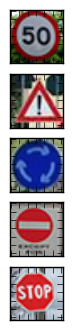

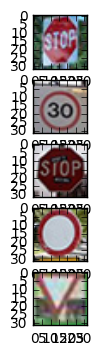

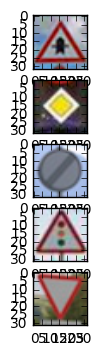

In [14]:
## Load the images and plot them here.
### Feel free to use as many code cells as needed.
from PIL import Image

test_imgs = np.uint8(np.zeros((15,32,32,3)))
other_tests = []

for i in range(1,16):
    image = Image.open("./web_cam/p_%d.jpg"%i)
    test_imgs[i-1] = image
    other_tests.append(np.array(image))

f, axarr = plt.subplots(5, 1)
for i in range(5):
    axarr[i].imshow(test_imgs[i])
    plt.setp(axarr[i].get_xticklabels(), visible=False)
    plt.setp(axarr[i].get_yticklabels(), visible=False) 

f, axarr1 = plt.subplots(5, 1)
for i in range(5,10):
    axarr1[i-5].imshow(test_imgs[i])
    plt.setp(axarr[i-5].get_xticklabels(), visible=False)
    plt.setp(axarr[i-5].get_yticklabels(), visible=False) 

f, axarr2 = plt.subplots(5, 1)
for i in range(10,15):
    axarr2[i-10].imshow(test_imgs[i])
    plt.setp(axarr[i-10].get_xticklabels(), visible=False)
    plt.setp(axarr[i-10].get_yticklabels(), visible=False) 



### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [21]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

other_features = convertToY(other_tests)
other_features = normalize_greyscale(other_features)

# Construct model

# other_input = tf.placeholder(tf.float32, [None, len(other_features)])

with tf.Session() as session:
    tf.initialize_all_variables().run()
    saver.restore(session, "./model.ckpt")
    print('Model restored with latest weights')
    
#     predictions = tf.nn.softmax(pred)
    
    pp = pred.eval({x: other_features, keep_prob:1.})
    top_k = session.run(tf.nn.top_k(pred, 5, sorted=True),feed_dict={x: other_features, keep_prob:1.})
#     predictions = session.run(tf.nn.softmax(pred),feed_dict={x: other_features, keep_prob:1.})
    
              
    print("Predicted Labels")
    print(np.argmax(pp, 1))

Model restored with latest weights
Predicted Labels
[ 0 18 40  9 14  4  1  8 15 13 11 12 32 11 13]


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

**The Result Comparation**

Labels | Result |
---|---
2|0
18|18
40|40
9|9
14|14
14|4
1|1
14|8
15|15
13|13
11|11
12|12
32|32
26|11
13|13

I estimate the result for all #1-#5 experiment, and find out the #5 generate the best result as above,
**The Accuracy is 11/15 = 0.73, other experiment like experiment #2 only reachs the accuracy up to 0.6** 

The captured pictures performs worse than testing dataset. It could be the reason of the angle, luminant, etc.

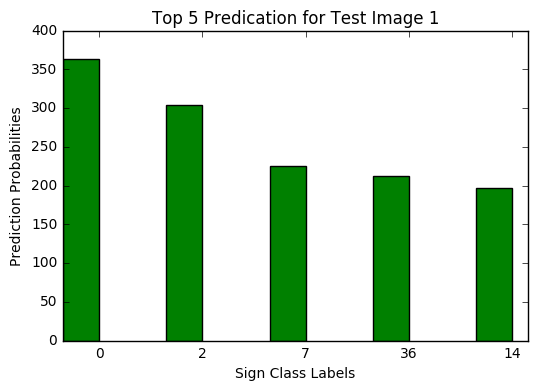

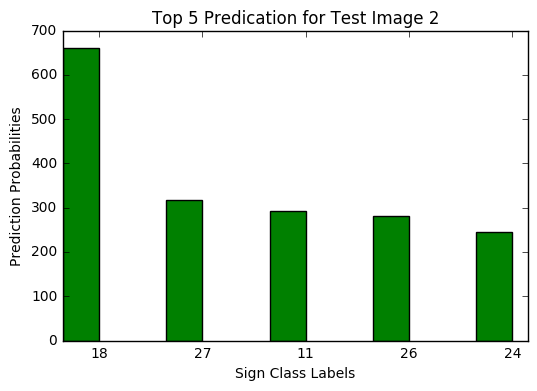

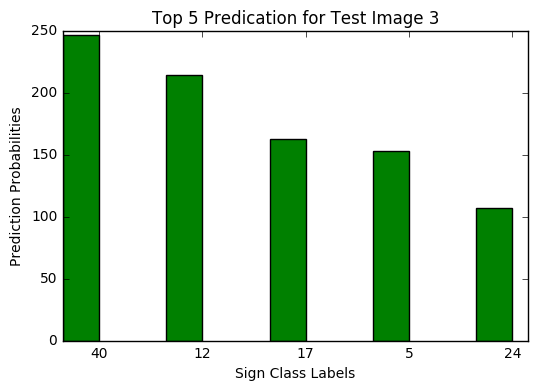

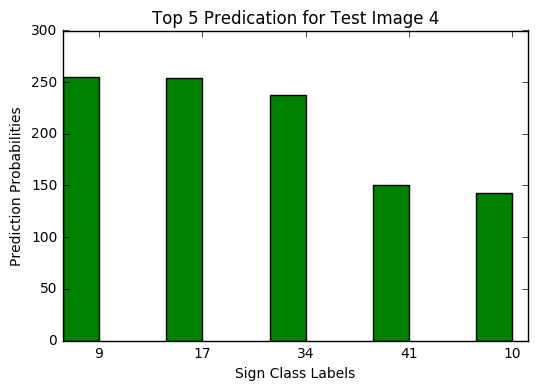

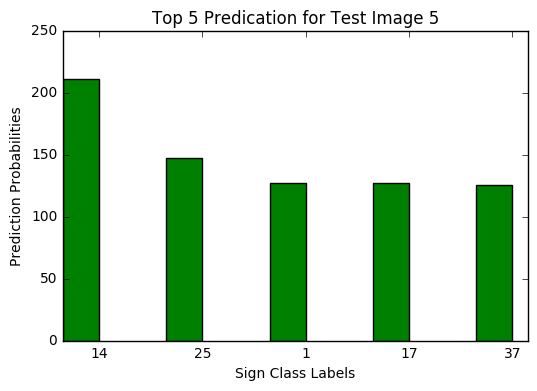

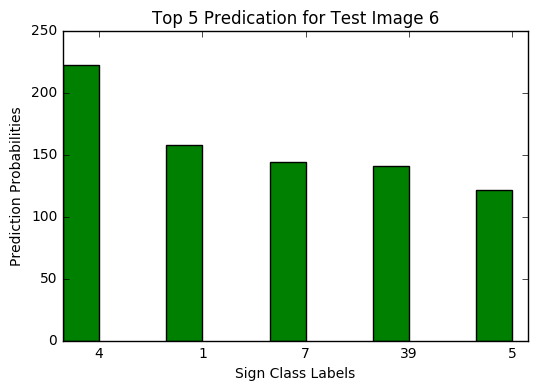

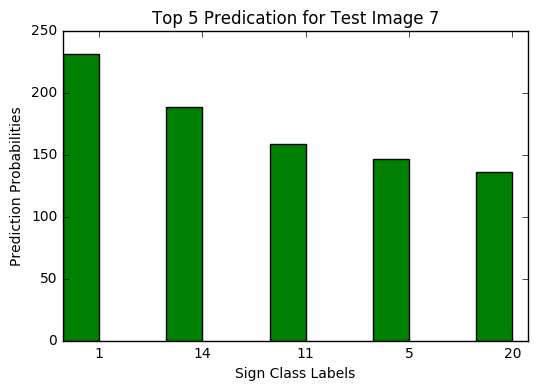

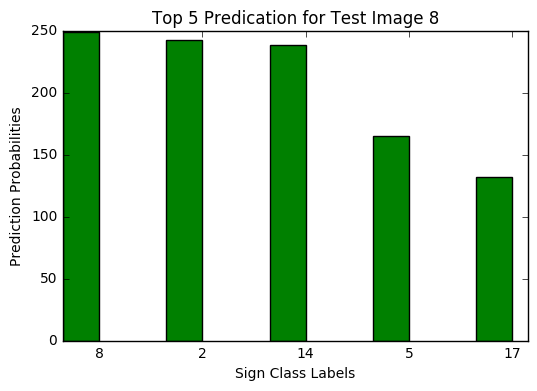

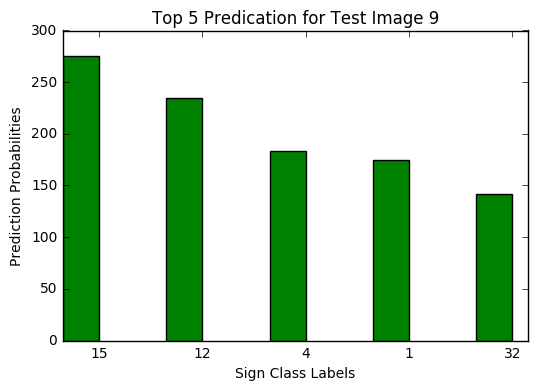

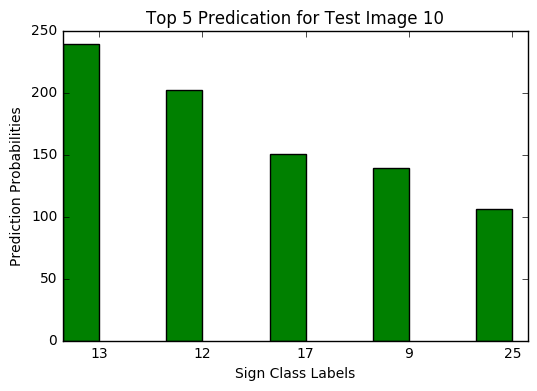

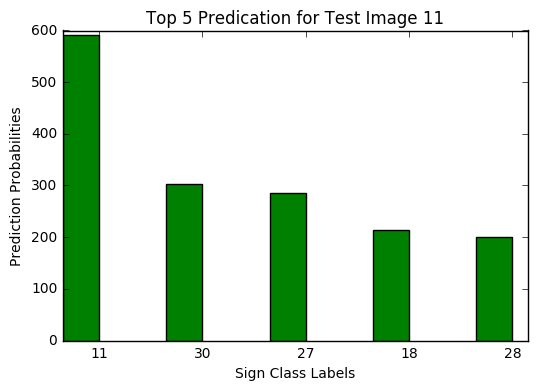

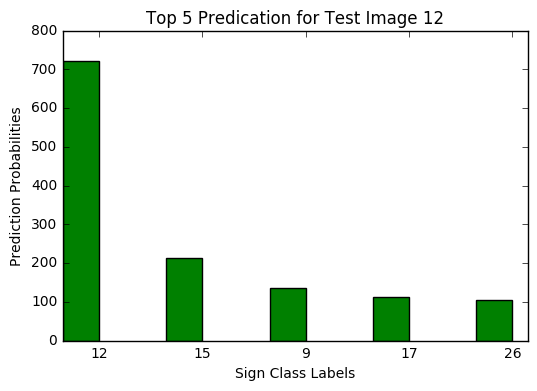

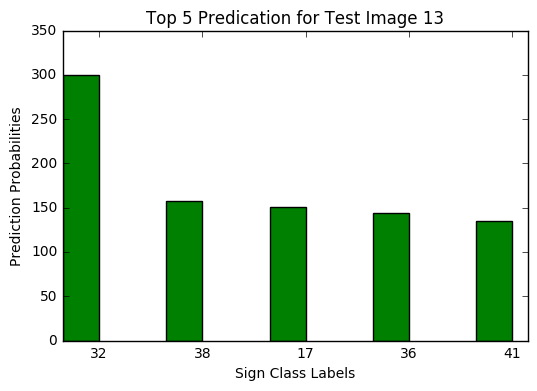

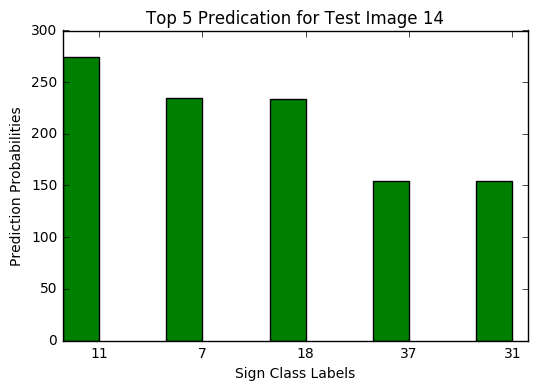

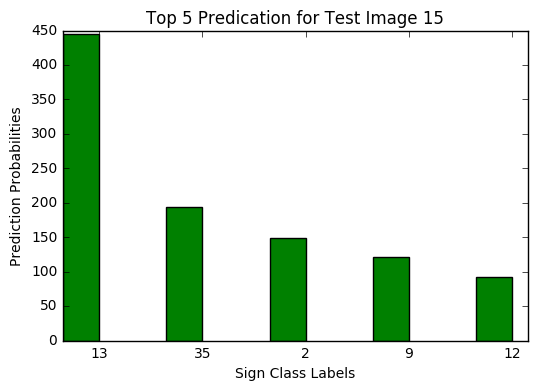

In [22]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

N = 5

ind = np.arange(N)  # the x locations for the values
width = 0.35       # the width of the bars

p1 = pp[0]

# sm1 = np.exp(p1) / np.sum(np.exp(p1), axis=1)

# Pull out values and indices for top 5 softmax probability analysis
top_k_values = top_k[0]
top_k_indices = top_k[1]

for i in range(15):
    plt.figure(i)
    values = top_k_values[i]
    plt.bar(ind, values, width, color='g')
    plt.ylabel('Prediction Probabilities')
    plt.xlabel('Sign Class Labels')
    plt.title('Top 5 Predication for Test Image {}'.format(str(i+1)))
    plt.xticks(ind+width, tuple(top_k_indices[i]))

plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

It seems that the softmax probabilities gives only 1 and 0, which suggests that we have pretty big difference between the predictions. So I used tf.nn.top_k on the fully connected layer result as above.

All the correct labels are all in the range of top 5 besides the 14th image(Traffic light) and 6th image(stop), I guess it could be the reason that ignoring the color channel make it more difficult to recognize with bad luminant and blur, and also it could be the reason of overfitting.

The model is quite sure to the result of image 2,5,11,12,13,15, while all of them generate the correct result.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

The images were reshaped manually and readed directly into the memory.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.